# `abcd_pyhf`: Likelihood-based ABCD method for background estimation and hypothesis testing with `pyhf`

An introduction to the likelihood-based ABCD method and how to use the Python package `abcd_pyhf` to implement it.

## Introduction

In analyses that are searching for new physics processes, the general idea is usually to look for a potential excess of signal-like events beyond the expected number of events from background processes. The expectations of what signal events might look like and how the background events are distributed are often provided by Monte Carlo (MC) simulation. However, it's often impractical or impossible to generate MC simulations that accurately model the background in the most signal-like regions and/or provide enough statistics to be useful for very low-background analyses. This is especially common for QCD multijet backgrounds, for example. This necessitates the use of data-driven background models, where the background in the signal region is estimated directly from data outside the signal region. Without making any further assumptions about the background, this requires at least two independent discriminant variables.

We'll look at an artificial example of signal MC and data to understand this. (This example was randomly generated in the [generate_example_data.ipynb notebook](generate_example_data.ipynb).) First, let's load the "signal MC":

In [1]:
import numpy as np

In [2]:
signal_mc = np.loadtxt('signal_mc.csv', delimiter=',')

This array consists of pairs of independent observables that I'll call $x$ and $y$. Each row represents one event. We can visualize this distribution in a 2D histogram:

In [3]:
import matplotlib.pyplot as plt

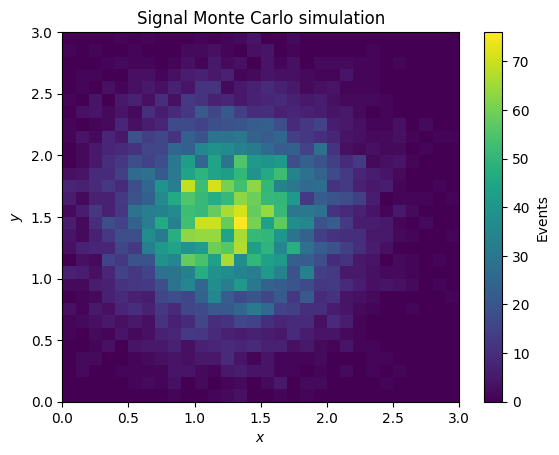

In [4]:
plt.hist2d(
    *signal_mc.T,
    bins=30,
    range=((0, 3), (0, 3))
)
plt.title('Signal Monte Carlo simulation')
plt.xlabel('$x$')
plt.xlim(0, 3)
plt.ylabel('$y$')
plt.ylim(0, 3)
plt.colorbar(label='Events')
plt.show()

As in a real analysis, we have a relatively high statistics sample of what this potential signal should look like in data if it exists. Of course we don't expect to see nearly this many signal events in real data, and we will have to deal with a distribution of background events in this plane.

Next, let's look at what our distribution of events in actual "data" looks like:

In [5]:
data = np.loadtxt('data.csv', delimiter=',')

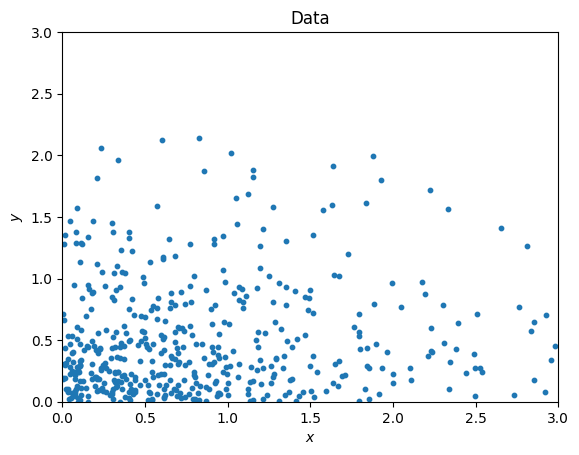

In [6]:
plt.scatter(*data.T, s=10)
plt.title('Data')
plt.xlabel('$x$')
plt.xlim(0, 3)
plt.ylabel('$y$')
plt.ylim(0, 3)
plt.show()

Now the question is: how do we know if there are real signal events here or not? In order to answer, we need a method to estimate how many of these events are from background processes.

## ABCD method

One of the simplest possible ways of estimating background from data is called the "ABCD method". In this method, we introduce threshold values in each of the two discriminants, separating this plane into four regions labeled $A$, $B$, $C$, and $D$:

In [7]:
x_threshold = 1
y_threshold = 1

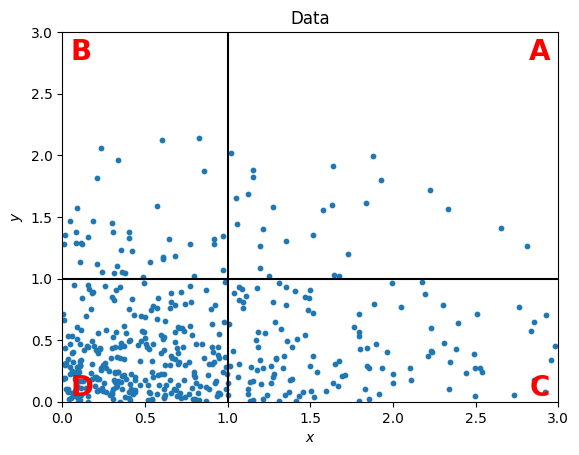

In [8]:
plt.scatter(*data.T, s=10)
plt.plot((0, 3), (y_threshold, y_threshold), color='black')
plt.plot((x_threshold, x_threshold), (0, 3), color='black')
plt.title('Data')
plt.xlabel('$x$')
plt.xlim(0, 3)
plt.ylabel('$y$')
plt.ylim(0, 3)
region_label_color = 'red'
region_label_fontsize = 20
region_label_fontweight = 'bold'
plt.text(2.95, 2.95, 'A', color=region_label_color, fontsize=region_label_fontsize, fontweight=region_label_fontweight, horizontalalignment='right', verticalalignment='top')
plt.text(0.05, 2.95, 'B', color=region_label_color, fontsize=region_label_fontsize, fontweight=region_label_fontweight, verticalalignment='top')
plt.text(2.95, 0.05, 'C', color=region_label_color, fontsize=region_label_fontsize, fontweight=region_label_fontweight, horizontalalignment='right')
plt.text(0.05, 0.05, 'D', color=region_label_color, fontsize=region_label_fontsize, fontweight=region_label_fontweight)
plt.show()

As long as $x$ and $y$ are statistically independent, it's easy to show that the number of events in region $A$, $N_A$ is approximately equal to $N_B N_C / N_D$, where the approximation is only due to finite statistics. Thus if $N_B$, $N_C$, and $N_D$ accurately reflect the number of background events in their respective regions, we have an unbiased estimator of the number of background events in region $A$ that does not rely on any information from region $A$.

Now let's look at the distribution of the simulated signal events:

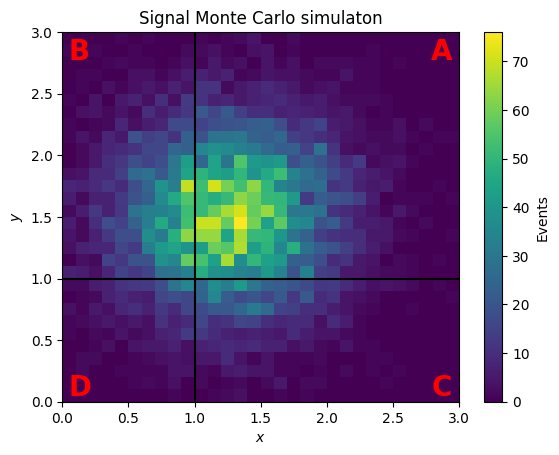

In [9]:
plt.plot((0, 3), (y_threshold, y_threshold), color='black')
plt.plot((x_threshold, x_threshold), (0, 3), color='black')
plt.hist2d(
    *signal_mc.T,
    bins=30,
    range=((0, 3), (0, 3))
)

plt.title('Signal Monte Carlo simulaton')
plt.xlabel('$x$')
plt.xlim(0, 3)
plt.ylabel('$y$')
plt.ylim(0, 3)
region_label_color = 'red'
region_label_fontsize = 20
region_label_fontweight = 'bold'
plt.text(2.95, 2.95, 'A', color=region_label_color, fontsize=region_label_fontsize, fontweight=region_label_fontweight, horizontalalignment='right', verticalalignment='top')
plt.text(0.05, 2.95, 'B', color=region_label_color, fontsize=region_label_fontsize, fontweight=region_label_fontweight, verticalalignment='top')
plt.text(2.95, 0.05, 'C', color=region_label_color, fontsize=region_label_fontsize, fontweight=region_label_fontweight, horizontalalignment='right')
plt.text(0.05, 0.05, 'D', color=region_label_color, fontsize=region_label_fontsize, fontweight=region_label_fontweight)
plt.colorbar(label='Events')
plt.show()

There is a significant amount leakage of signal events into regions $B$, $C$, and $D$. So if there really are any signal events observed in data in region $A$, there very likely are signal events in data in the other regions as well. This unfortunately breaks the naive ABCD method, and if we tried to use it, we could end up totally missing our observation of signal in data.

### Likelihood-based

The correct and much more robust way to handle this scenario is to use the "likelihood-based" ABCD method. In this method, we set up a system of equations.

Expected number of signal events in each region:

$n_X^\textrm{signal} = (\epsilon_X / \epsilon_A) \mu$

where $\epsilon_X$ is the signal efficiency of region $X$ ($X \in \{A, B, C, D\}$) estimated from MC and $\mu$ is the signal strength, defined as the number of signal events in data in region $A$.

Expected number of background events in each region:

$n_A^\textrm{bkg} = \mu_b$

$n_B^\textrm{bkg} = \tau_B \mu_b$

$n_C^\textrm{bkg} = \tau_C \mu_b$

$n_D^\textrm{bkg} = \tau_B \tau_C \mu_b$

where $\mu_b$ is defined to be the number of background events in region $A$ and $\tau_B$ and $\tau_C$ are nuisance parameters that enforce the standard ABCD relation $n_A^\textrm{bkg} = n_B^\textrm{bkg} n_C^\textrm{bkg} / n_D^\textrm{bkg}$.

Then the total expected number of events in region $X$ is $n_X = n_X^\textrm{signal} + n_X^\textrm{bkg}$. For particular values of all these parameters, we can calculate a Poisson likelihood based on the expected number of events and the observed number of events in each region. At this point, we can perform maximum likelihood fits with these parameters in order to do all statistical tests needed to get our analysis results.

## `abcd_pyhf`

`abcd_pyhf` is a Python package that facilitates doing exactly these statistical tests. It's a convenient wrapper around `pyhf`, which is used to build the proper PDFs and run hypothesis tests for the likelihood-based ABCD method.

First we need to extract the yields (the number of events in each region for signal MC and data). I'll use a simple function for this counting:

In [10]:
def get_region_counts(x, y, x_cut, y_cut):
    return {
        'A': sum((x > x_cut) & (y > y_cut)),
        'B': sum((x > 0) & (x < x_cut) & (y > y_cut)),
        'C': sum((x > x_cut) & (y > 0) & (y < y_cut)),
        'D': sum((x > 0) & (x < x_cut) & (y > 0) & (y < y_cut))
    }

and then evaluate these yields in data and signal MC:

In [11]:
data_yields = get_region_counts(*data.T, x_threshold, y_threshold)
signal_mc_yields = get_region_counts(*signal_mc.T, x_threshold, y_threshold)

We also need the total systematic uncertainty for this analysis. This is a complicated number that would normally be the product of many dedicated studies. In this example, I'll just arbitrarily set it to 10%:

In [12]:
signal_uncertainty = 0.1

### `ABCD`

The main class used in `abcd_pyhf` is called `ABCD`, which is an object that carries the information about a particular ABCD plane, including the yields from signal MC and data, as well as the systematic uncertainty. I'll pass in this information to make a new `abcd` object:

In [13]:
from abcd_pyhf import ABCD

In [14]:
abcd = ABCD(data_yields, signal_mc_yields, signal_uncertainty)

### Parameter fitting

One of the lower-level tasks that `abcd_pyhf` can do is extracting the maximum likelihood estimators (MLEs) of the fit parameters and their uncertainty based on the observed data.

We can inspect the parameters used in fitting:

In [15]:
abcd.model.config.par_names

['mu_b', 'mu', 'tau_B', 'tau_C', 'systematic_uncertainty']

and we can run the fit with the signal strength fixed to zero (a background-only fit):

In [16]:
abcd.bkg_only_fit()

array([[27.71897765,  3.5643251 ],
       [ 0.        ,  0.        ],
       [ 1.74226532,  0.16027658],
       [ 5.71076759,  0.71037045],
       [ 0.        ,  0.9933467 ]])

or fit while allowing all parameters to float, so that the signal strength is at its MLE:

In [17]:
abcd.fit()

array([[ 2.02398825e+01,  5.70131472e+00],
       [ 1.27302310e+01,  9.22152418e+00],
       [ 1.85899899e+00,  1.94304056e-01],
       [ 7.44257607e+00,  1.88436828e+00],
       [-6.53906534e-04,  9.93220603e-01]])

The first column represents the parameter values, and the second column is the uncertainty. The second row is the signal strength, so $\mu = 13 \pm 9$ based on the fit.

### Likelihood values

We can also extract the likelihood at various parameter values.

`twice_nll()` gets the likelihood at several values of $\mu$:

In [18]:
abcd.twice_nll()

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62.]),
 array([[1.82729307e+00],
        [1.55776722e+00],
        [1.30815495e+00],
        [1.07906501e+00],
        [8.71043309e-01],
        [6.84568109e-01],
        [5.20044624e-01],
        [3.77801393e-01],
        [2.58087860e-01],
        [1.61072657e-01],
        [8.68441104e-02],
        [3.54108502e-02],
        [6.70422505e-03],
        [5.81539165e-04],
        [1.68299493e-02],
        [5.51713684e-02],
        [1.15267189e-01],
        [1.96724577e-01],
        [2.99101926e-01],
        [4.21913979e-01],
        [5.64640581e-01],
        [7.26730106e-01],
        [9.07607363e-01],
        [1.10667918e+00],
        [1.32334147

and there's a convenience function (`twice_nll_plot()`) to plot this result:

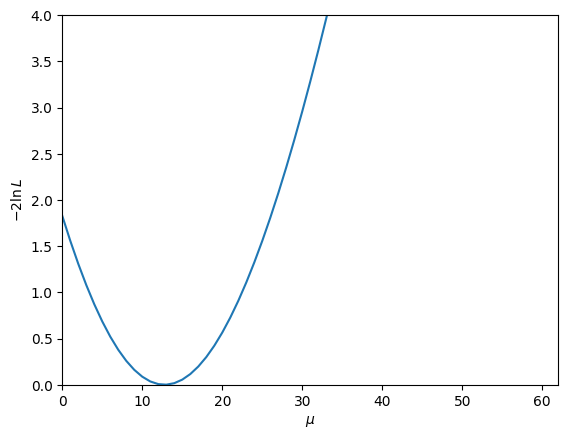

In [19]:
abcd.twice_nll_plot()
plt.ylim(0, 4)
plt.show()

While the favored value of $\mu$ is around 13, we certainly can't exclude a signal-free hypothesis ($\mu = 0$)

### $\textrm{CL}_s$ tests

We can easily extract $\textrm{CL}_b$, $\textrm{CL}_{s + b}$, and $\textrm{CL}_s$, which are used by LHC experiments for discovery and setting upper limits on signal strength [[arXiv:1007.1727](https://arxiv.org/abs/1007.1727)]:

In [20]:
abcd.clb()

/home/user/micromamba/envs/pyhf-workshop-2023-abcd-pyhf/lib/python3.10/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62.]),
 array([0.5       , 0.5408116 , 0.58129548, 0.62099897, 0.65949482,
        0.69639607, 0.73136858, 0.76414134, 0.79451152, 0.8223469 ,
        0.84758394, 0.87022351, 0.89032302, 0.90394273, 0.90290991,
        0.90182914, 0.90070389, 0.89953774, 0.89833465, 0.89709884,
        0.89583447, 0.89454602, 0.89323815, 0.89191547, 0.89058268,
        0.88924434, 0.8879048 , 0.88656798, 0.88523736, 0.88391589,
        0.88260576, 0.88130845, 0.88002452, 0.87875375, 0.87749483,
        0.87624548, 0.87500239, 0.8737639 , 0.87252937, 0.87129845,
        0.87007143, 0.86884934, 0.86763419, 0.86642912, 0.86523573,
        0.86405425, 0.8628848 ,

In [21]:
abcd.clsb()

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62.]),
 array([5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
        5.00000000e-01, 4.90380390e-01, 4.48389907e-01, 4.07148661e-01,
        3.67112700e-01, 3.28688882e-01, 2.92222990e-01, 2.57991774e-01,
        2.26198251e-01, 1.96972573e-01, 1.70375027e-01, 1.46402481e-01,
        1.24996620e-01, 1.06053673e-01, 8.94344397e-02, 7.49740710e-02,
        6.24916038e-02, 5.17980258e-02, 4.27032848e-02, 3.50219183e-02,
        2.85772477e-02, 2.32044915e-02, 1.87525935e-02, 1.50852663e

In the case of $\textrm{CL}_s$, we get the observed values as well as the expected band, which is the median value (assuming the true value of $\mu$ is zero), $\pm 1 \sigma$, and $\pm 2 \sigma$.

In [22]:
abcd.cls()

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62.]),
 array([1.00000000e+00, 9.24536384e-01, 8.60147748e-01, 8.05154317e-01,
        7.58156067e-01, 7.17982227e-01, 6.83649825e-01, 6.54329212e-01,
        6.29317498e-01, 6.08015913e-01, 5.89912071e-01, 5.74565032e-01,
        5.61593928e-01, 5.42490554e-01, 4.96605368e-01, 4.51469847e-01,
        4.07584231e-01, 3.65397546e-01, 3.25294131e-01, 2.87584558e-01,
        2.52500052e-01, 2.20192777e-01, 1.90738637e-01, 1.64143897e-01,
        1.40353752e-01, 1.19262692e-01, 1.00725258e-01, 8.45666355e-02,
        7.05930481e-02, 5.86006274e-02, 4.83831931e-02, 3.97385480e-02,
        3.24732404e-02, 2.64061366e-02, 2.13706027e-02, 1.72157993e

### Brazil plot

There's another convenience function for plotting the $\textrm{CL}_s$ band, sometimes called a "Brazil plot":

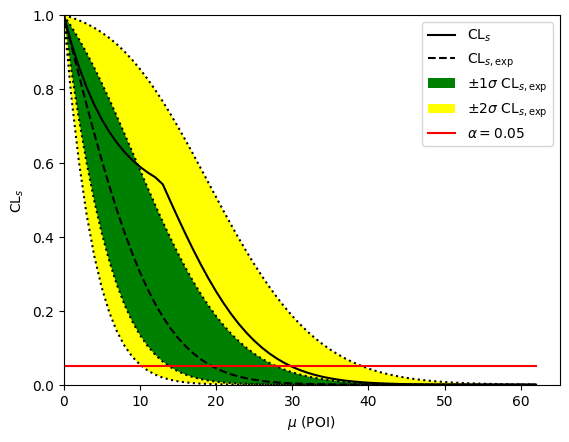

In [23]:
abcd.brazil_plot()
plt.xlim(0)
plt.show()

### Upper limits

And finally we can extract the observed and expected upper limit band for the signal strength (where the lines in the plot above cross 0.05, for a 95% confidence level):

In [24]:
abcd.upper_limit()

(29.841759992704965,
 [10.283106269839395,
  13.854479651341673,
  19.499985975329853,
  27.908420475843002,
  39.19408934154968])

## Summary and outlook

- The ABCD method
    - One of the simplest and most common data-driven background estimation methods
    - Really a family of many methods using very similar techniques, but almost all that are actually used in modern analyses are some variant of the likelihood-based method described here
- `abcd_pyhf`
    - A small, pure-Python package
    - Depends only on NumPy, Matplotlib, and `pyhf`
        - No dependence on experiment-specific formats or code
    - Works out of the box for most simple cases
        - Intended to be extensible to accommodate more complicated cases
    - Using this for my own ATLAS analysis, and a few other ATLAS analyses are using or trying out this package

## Links

- [GitHub repository](https://github.com/masonproffitt/abcd-pyhf)
- [PyPI package](https://pypi.org/project/abcd-pyhf/)
- [ACAT 2021 poster](https://indico.cern.ch/event/855454/contributions/4596707/)
- [PyHEP 2022 presentation](https://indico.cern.ch/event/1150631/timetable/#17-abcd_pyhf-likelihood-based)